In [21]:
## Step 1: Load Data and Initial Exploration

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
file_paths = {
    "image1": "Lab 4/Data /image1.txt",
    "image2": "Lab 4/Data /image2.txt",
    "image3": "Lab 4/Data /image3.txt"
}

# Load the data into dataframes
data = {name: pd.read_csv(path, delim_whitespace=True, header=None) for name, path in file_paths.items()}

# Assign column names based on the description
columns = ['x', 'y', 'label', 'NDAI', 'SD', 'CORR', 'Radiance_angle1', 'Radiance_angle2', 
           'Radiance_angle3', 'Radiance_angle4', 'Radiance_angle5']
for name, df in data.items():
    df.columns = columns

# Inspect the first few rows of each file
for name, df in data.items():
    print(f"--- {name} ---")
    print(df.head())

--- image1 ---
       x     y  label      NDAI        SD      CORR  Radiance_angle1  \
0  373.0  65.0   -1.0 -0.228591  1.752265  0.105434        271.62891   
1  374.0  65.0   -1.0 -0.205959  1.875819  0.113432        272.31284   
2  375.0  65.0   -1.0  0.019373  2.286991  0.114524        274.61032   
3  376.0  65.0   -1.0 -0.303432  2.822642  0.107892        276.65012   
4  377.0  65.0   -1.0 -0.675589  3.656925  0.102998        275.60010   

   Radiance_angle2  Radiance_angle3  Radiance_angle4  Radiance_angle5  
0        261.33844        251.83549        233.98555        219.14351  
1        262.95920        252.11003        234.83566        218.55107  
2        263.17834        251.78252        233.68451        219.46140  
3        261.89957        250.35201        234.05057        220.41025  
4        259.69360        250.37851        234.48888        221.05806  
--- image2 ---
       x     y  label      NDAI         SD      CORR  Radiance_angle1  \
0  352.0  65.0    0.0  1.716874 

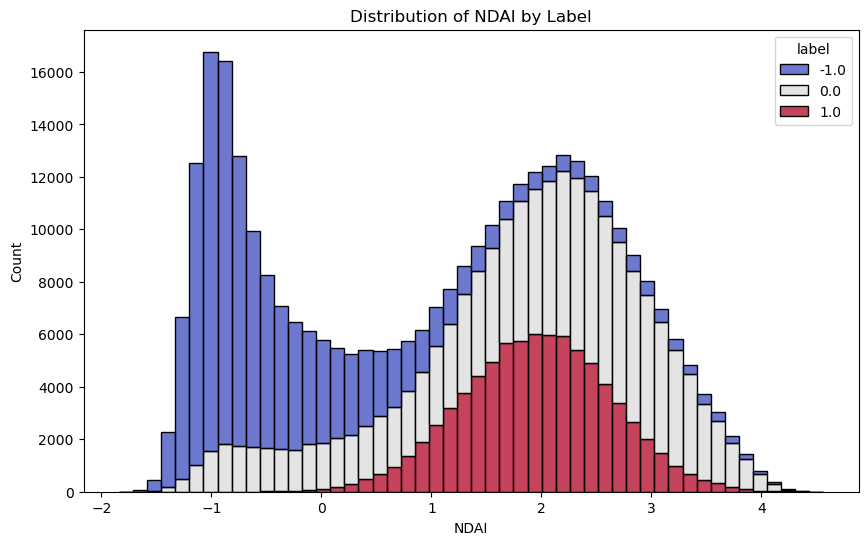

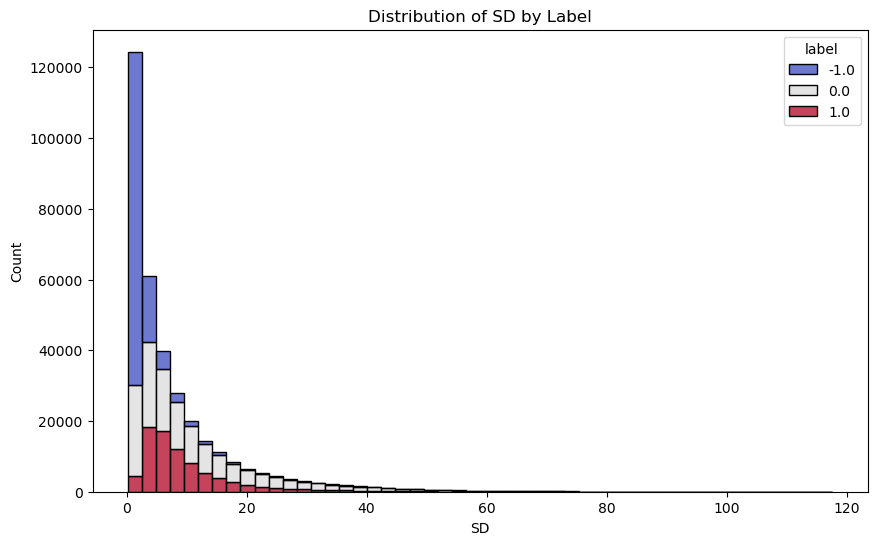

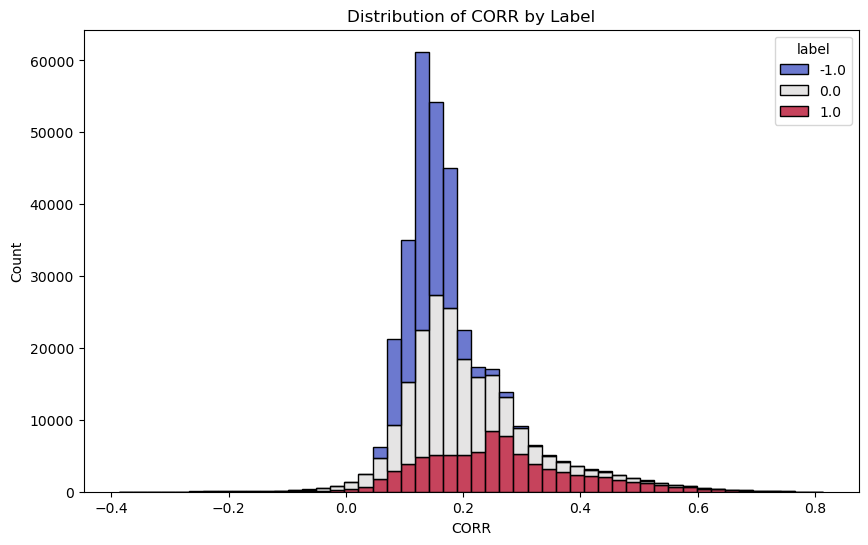

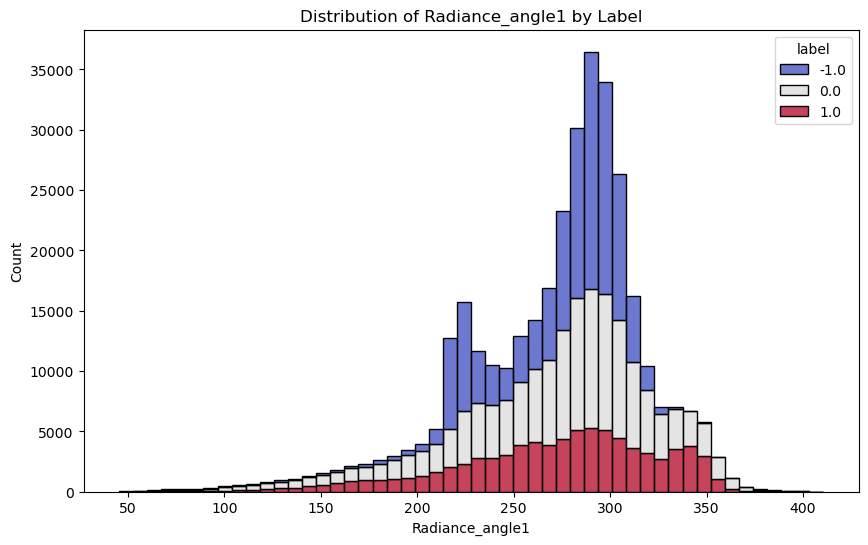

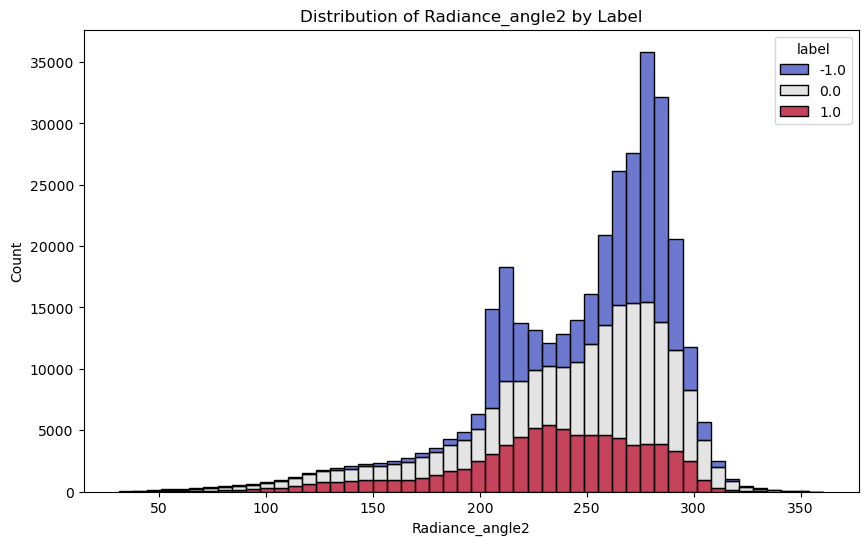

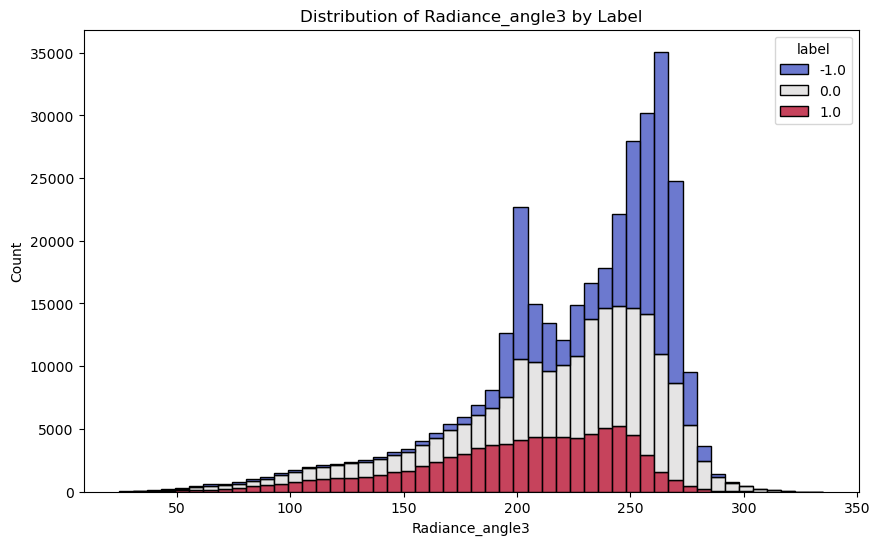

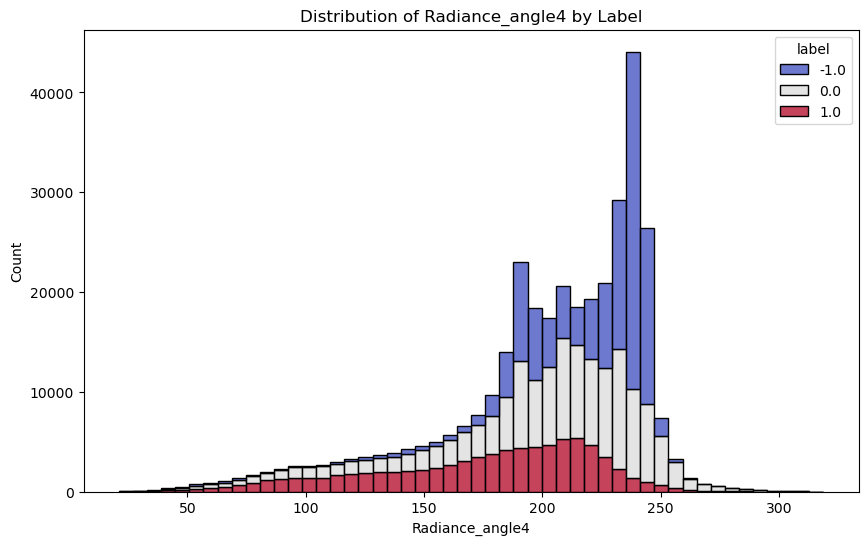

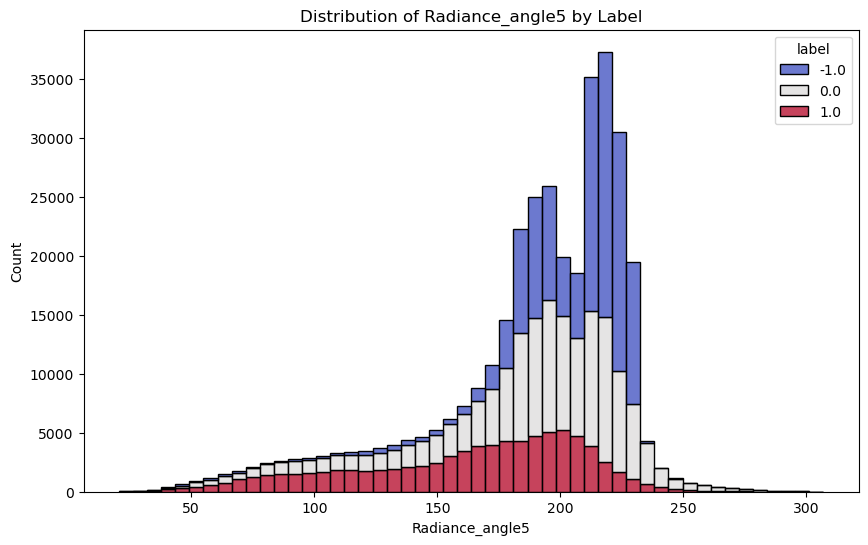

In [6]:
## Step 2: Exploratory Data Analysis (EDA)

# Combine data into a single DataFrame for EDA
combined_data = pd.concat(data, keys=["image1", "image2", "image3"]).reset_index(level=0).rename(columns={"level_0": "source"})

# Plot distributions of each feature, segmented by label
for feature in columns[3:]:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_data, x=feature, hue="label", multiple="stack", bins=50, palette="coolwarm")
    plt.title(f"Distribution of {feature} by Label")
    plt.show()

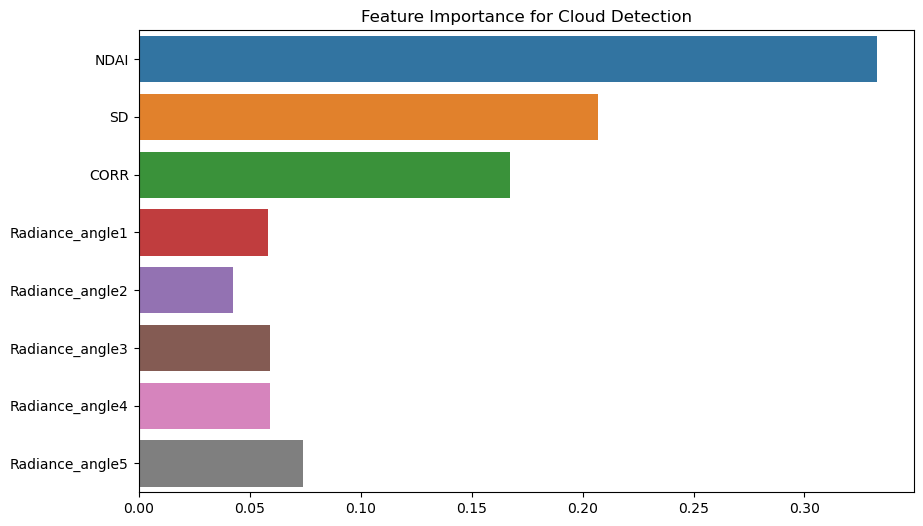

In [7]:
## Step 3: Feature Selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Filter labeled data (exclude rows with label 0)
labeled_data = combined_data[combined_data['label'] != 0]

# Separate features and labels
X = labeled_data[columns[3:]]
y = labeled_data['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a random forest classifier to estimate feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled, y)
importances = clf.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=columns[3:])
plt.title("Feature Importance for Cloud Detection")
plt.show()

2024-11-07 09:53:22.579507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 09:53:25.900473: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 09:53:25.939732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 09:53:41.932203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50
651/651 [==============================] - 2s 932us/step - loss: 1.0499 - val_loss: 1.0543
Epoch 2/50
651/651 [==============================] - 0s 754us/step - loss: 0.7561 - val_loss: 0.9222
Epoch 3/50
651/651 [==============================] - 0s 754us/step - loss: 0.7210 - val_loss: 0.7965
Epoch 4/50
651/651 [==============================] - 1s 772us/step - loss: 0.6995 - val_loss: 0.7564
Epoch 5/50
651/651 [==============================] - 1s 794us/step - loss: 0.6924 - val_loss: 0.7274
Epoch 6/50
651/651 [==============================] - 0s 760us/step - loss: 0.6879 - val_loss: 0.6981
Epoch 7/50
651/651 [==============================] - 0s 752us/step - loss: 0.6837 - val_loss: 0.6705
Epoch 8/50
651/651 [==============================] - 0s 763us/step - loss: 0.6806 - val_loss: 0.6513
Epoch 9/50
651/651 [==============================] - 0s 758us/step - loss: 0.6788 - val_loss: 0.6445
Epoch 10/50
651/651 [==============================] - 0s 755us/step - loss: 0.677

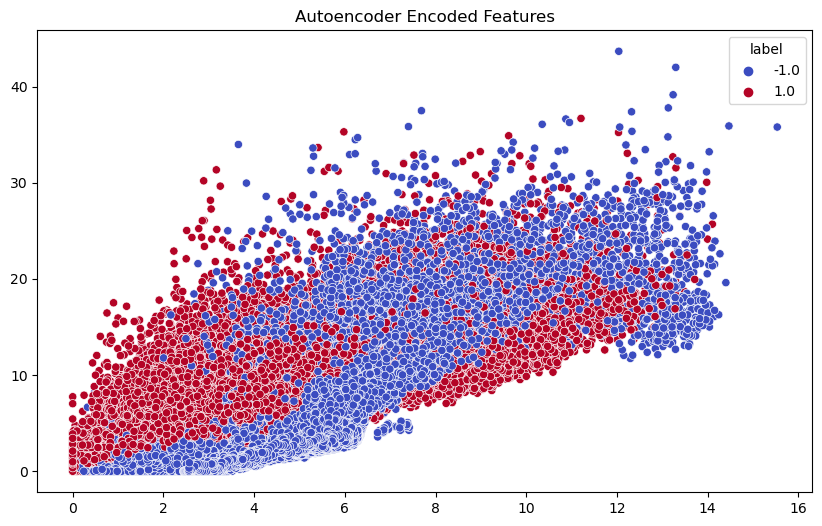

In [8]:
## Step 4: Autoencoder for Feature Engineering

import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 3  

# Autoencoder model
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_layer, decoded)
encoder = models.Model(input_layer, encoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Use the encoder to transform features into the lower-dimensional space
X_encoded = encoder.predict(X_scaled)

# Visualize the encoded features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_encoded[:, 0], y=X_encoded[:, 1], hue=y, palette="coolwarm")
plt.title("Autoencoder Encoded Features")
plt.show()

In [22]:
## Step 5: Logistic Regression
## Do hyper parameters and cross validation on image 1 and image 2 (Look Anqui code)
## Pull and push my work in the group repository

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Split data into training, validation, and test sets
train_data = labeled_data[labeled_data['source'] == 'image1']
val_data = labeled_data[labeled_data['source'] == 'image2']
test_data = labeled_data[labeled_data['source'] == 'image3']

X_train, y_train = train_data[columns[3:]], train_data['label']
X_val, y_val = val_data[columns[3:]], val_data['label']
X_test, y_test = test_data[columns[3:]], test_data['label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Perform cross-validation
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=2)
print("Cross-validation scores:", scores)
print("Cross-validation mean score:", scores.mean())

# Train logistic regression model on full training set
log_reg.fit(X_train_scaled, y_train)

# Evaluate model on validation set
y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# Evaluate model on test set
y_test_pred = log_reg.predict(X_test_scaled)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))
print("Test set confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

Cross-validation scores: [0.8807919  0.82083028]
Cross-validation mean score: 0.850811089290139
              precision    recall  f1-score   support

        -1.0       0.62      0.92      0.74     42882
         1.0       0.81      0.37      0.51     39266

    accuracy                           0.66     82148
   macro avg       0.71      0.65      0.62     82148
weighted avg       0.71      0.66      0.63     82148

[[39332  3550]
 [24584 14682]]
Test set classification report:
              precision    recall  f1-score   support

        -1.0       0.75      0.83      0.79     33752
         1.0       0.67      0.55      0.61     21244

    accuracy                           0.72     54996
   macro avg       0.71      0.69      0.70     54996
weighted avg       0.72      0.72      0.72     54996

Test set confusion matrix:
[[28044  5708]
 [ 9539 11705]]


/tmp/ipykernel_2086333/4025964687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['predicted_label'] = y_pred


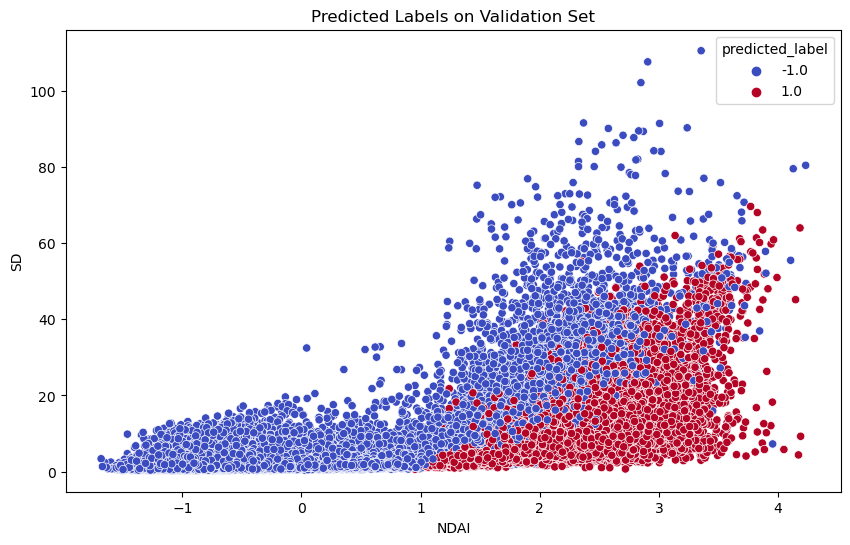

In [12]:
## Step 7: Visualize Predictions on Validation Set

import matplotlib.pyplot as plt
import seaborn as sns

# Combine validation data and predictions
val_data['predicted_label'] = y_pred

# Create a scatter plot of the validation data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=val_data, x='NDAI', y='SD', hue='predicted_label', palette='coolwarm')
plt.title('Predicted Labels on Validation Set')
plt.xlabel('NDAI')
plt.ylabel('SD')
plt.show()

/tmp/ipykernel_2086333/762574137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_label'] = y_test_pred


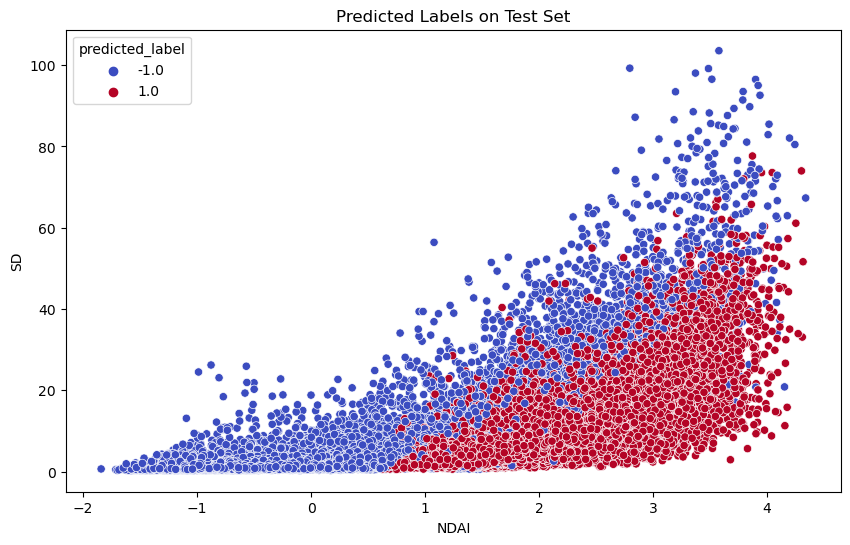

In [14]:
## Visualize Predictions on Test Set

# Combine test data and predictions
test_data['predicted_label'] = y_test_pred

# Create a scatter plot of the test data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=test_data, x='NDAI', y='SD', hue='predicted_label', palette='coolwarm')
plt.title('Predicted Labels on Test Set')
plt.xlabel('NDAI')
plt.ylabel('SD')
plt.show()